# DSCI 561 Lab 3 - Question 2

Usual lab instructions are here.

## Grading Scheme

Many of you are familiar with the "Traditional Grading" model that is in place in most courses.
Briefly, this model involves earning (or losing) points on individual assessments throughout the course, and then a grade calculated by doing a "weighted-average" throughout the term.

You may be surprised to learn that this is not the only way classes can be structured, and there are alternative models that research has shown to be far better for learning, motivation, attitudes, and long-term benefit.
If you're interested in learning more details about the last sentence (and if it surprises you), I encourage you to [check out this very accessible paper](https://www.lifescied.org/doi/full/10.1187/cbe.cbe-14-03-0054) from Drs. {cite:t}`Schinske:2014`.

I am not quite ready to fully move away from Traditional Grading yet (mostly because of a lack of resources, otherwise I'm totally all-in!) but I'd like to experiment with a modified version of Specifications-Grading here in this course.
I'd love to hear your feedback on it!
Here are some [key features](https://twitter.com/siwelwerd/status/1472940473924960261) of Specifications Grading:

- Each assignment is accompanied with a clear list of "specifications" of what constitutes acceptable work at each level.
- Assignments are marked based on whether students have met each of the specifications for that assignment.
- Students are given multiple opportunities to revise their work to demonstrate their learning.

In this course, {numref}`specifications_rubric` shows a handy guide to help you understand this grading system: 

```{figure} ../images/specifications_rubric.png
---
height: 400px
name: specifications_rubric
---
This table describes how I think each course activity should be classified between knowledge transfer and sense-making.
```
I prefer **not** to associate percentages or grades to the levels (I personally feel that this hampers your learning and poisons motivation and creativity), but I know that it will take us some time to eliminate grades completely.
If you must think of things in terms of numbers and percentages, you can expand the box below to see my best guess of what each level translates into.

```{admonition} Resist the temptation to click this button!
:class: dropdown
Some hidden toggle content!

- The **E** level is about 100%.
- The **G** level is about 85%.
- The **R** level is < 50%.
- The **I** level does not have a number associated, because it was not graded.
```

### Resubmission Policy

This term, you will be able to resubmit your work up to a maximum of 2 times after you have receive feedback.
Each time you do a resubmission, you will first need to reflect on your initial submission, and discuss how you corrected your work after receiving feedback from the TAs.

Your resubmission request can be submitted on Gradescoope but we reserve the right to decline your resubmission if your reflection is not up to our specifications.


## Pre-requisite Knowledge

Before doing this lab, students should:

- be comfortable performing Exploratory Data Analysis (EDA).
- be able to perform the mechanics of performing linear regressions in R using the `tidyverse`.
- be able to identify collinearity and multi-collinearity in variables using a variety of methods (correlation matrix, correlogram, visualizations, variance inflation factor, etc...).

## Learning Intentions

In [15]:
# Load libraries

# Adjust plot aspect ratio and apperance
library(repr)
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 400)

library("tidyverse")
library("moderndive")

suppressPackageStartupMessages({
  library("janitor")
  library("car")
  library("corrplot")
  library("ISLR")
  library("plotly")
  library("cowplot")
})

# Only display 10 rows of tibble
repr_html.tbl_df <- function(obj, ..., rows = 10) repr:::repr_html.data.frame(obj, ..., rows = rows)

## 2.0 - Introduction

In this question, you will continue your analysis of the `boston` dataset.
In question 1 of this lab, you have already done some exploratory data analysis of the `boston` dataset, but we are repeating the same introductory information here for completeness.

### Housing Values in Suburbs of Boston

This is an old dataset about house values in the suburbs of Boston in the year 1978.
It contains 14 columns, and 506 rows and each row indicates a different "town" in Boston.
`MEDV` is the median value of owner-occupied homes and is generally considered to be the response variable.

The columns and their descriptions are provided below:

| Column | Description |
| ------ | ----------- |
|CRIM | per capita crime rate by town|
|ZN | proportion of residential land zoned for lots over 25,000 sq.ft.|
|INDUS | proportion of non-retail business acres per town|
|CHAS | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)|
|NOX | nitric oxides concentration (parts per 10 million)|
|RM | average number of rooms per dwelling|
|AGE | proportion of owner-occupied units built prior to 1940|
|DIS | weighted distances to five Boston employment centres|
|RAD | index of accessibility to radial highways|
|TAX | full-value property-tax rate per \$10,000|
|PTRATIO | pupil-teacher ratio by town|
|B | 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town|
|LSTAT | % lower status of the population|
|MEDV | Median value of owner-occupied homes|

**N.B. I am intentionally giving you a flawed dataset for this lab so that you can carefully and critically consider some of the ethical questions that arise while working with this, and other data. If you feel that doing this lab would cause you harm (for instance, as a result of reliving personal trauma), please let me know and I'll provide you an alternative dataset.**

## 2.1 - Load the dataset

**Specifications**

- Load the dataset and bind it to a variable called `boston`.

In [16]:
# Your code here

boston <- read_csv("boston.csv", col_types = cols())
boston

CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.06263,0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21,391.99,9.67,22.4
0.04527,0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21,396.90,9.08,20.6
0.06076,0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21,396.90,5.64,23.9


## 2.1 - Correllogram

**Specifications**

- Create a correllogram using the [`corrplot` package](https://cran.r-project.org/web/packages/corrplot/vignettes/corrplot-intro.html) of all the numeric variables in the `boston` dataset.
- You may use the `cor()` or a simialr function, but you should NOT calculate the correlations manually.
- Round your correlations to 2 significant figures.
- Ensure that you explore some of the options [available in the documentation](https://cran.r-project.org/web/packages/corrplot/vignettes/corrplot-intro.html) to customize your correllogram for this dataset.
- Ensure that there is no repeated or duplicated information in your correllogram (i.e. choose upper or lower triangle)

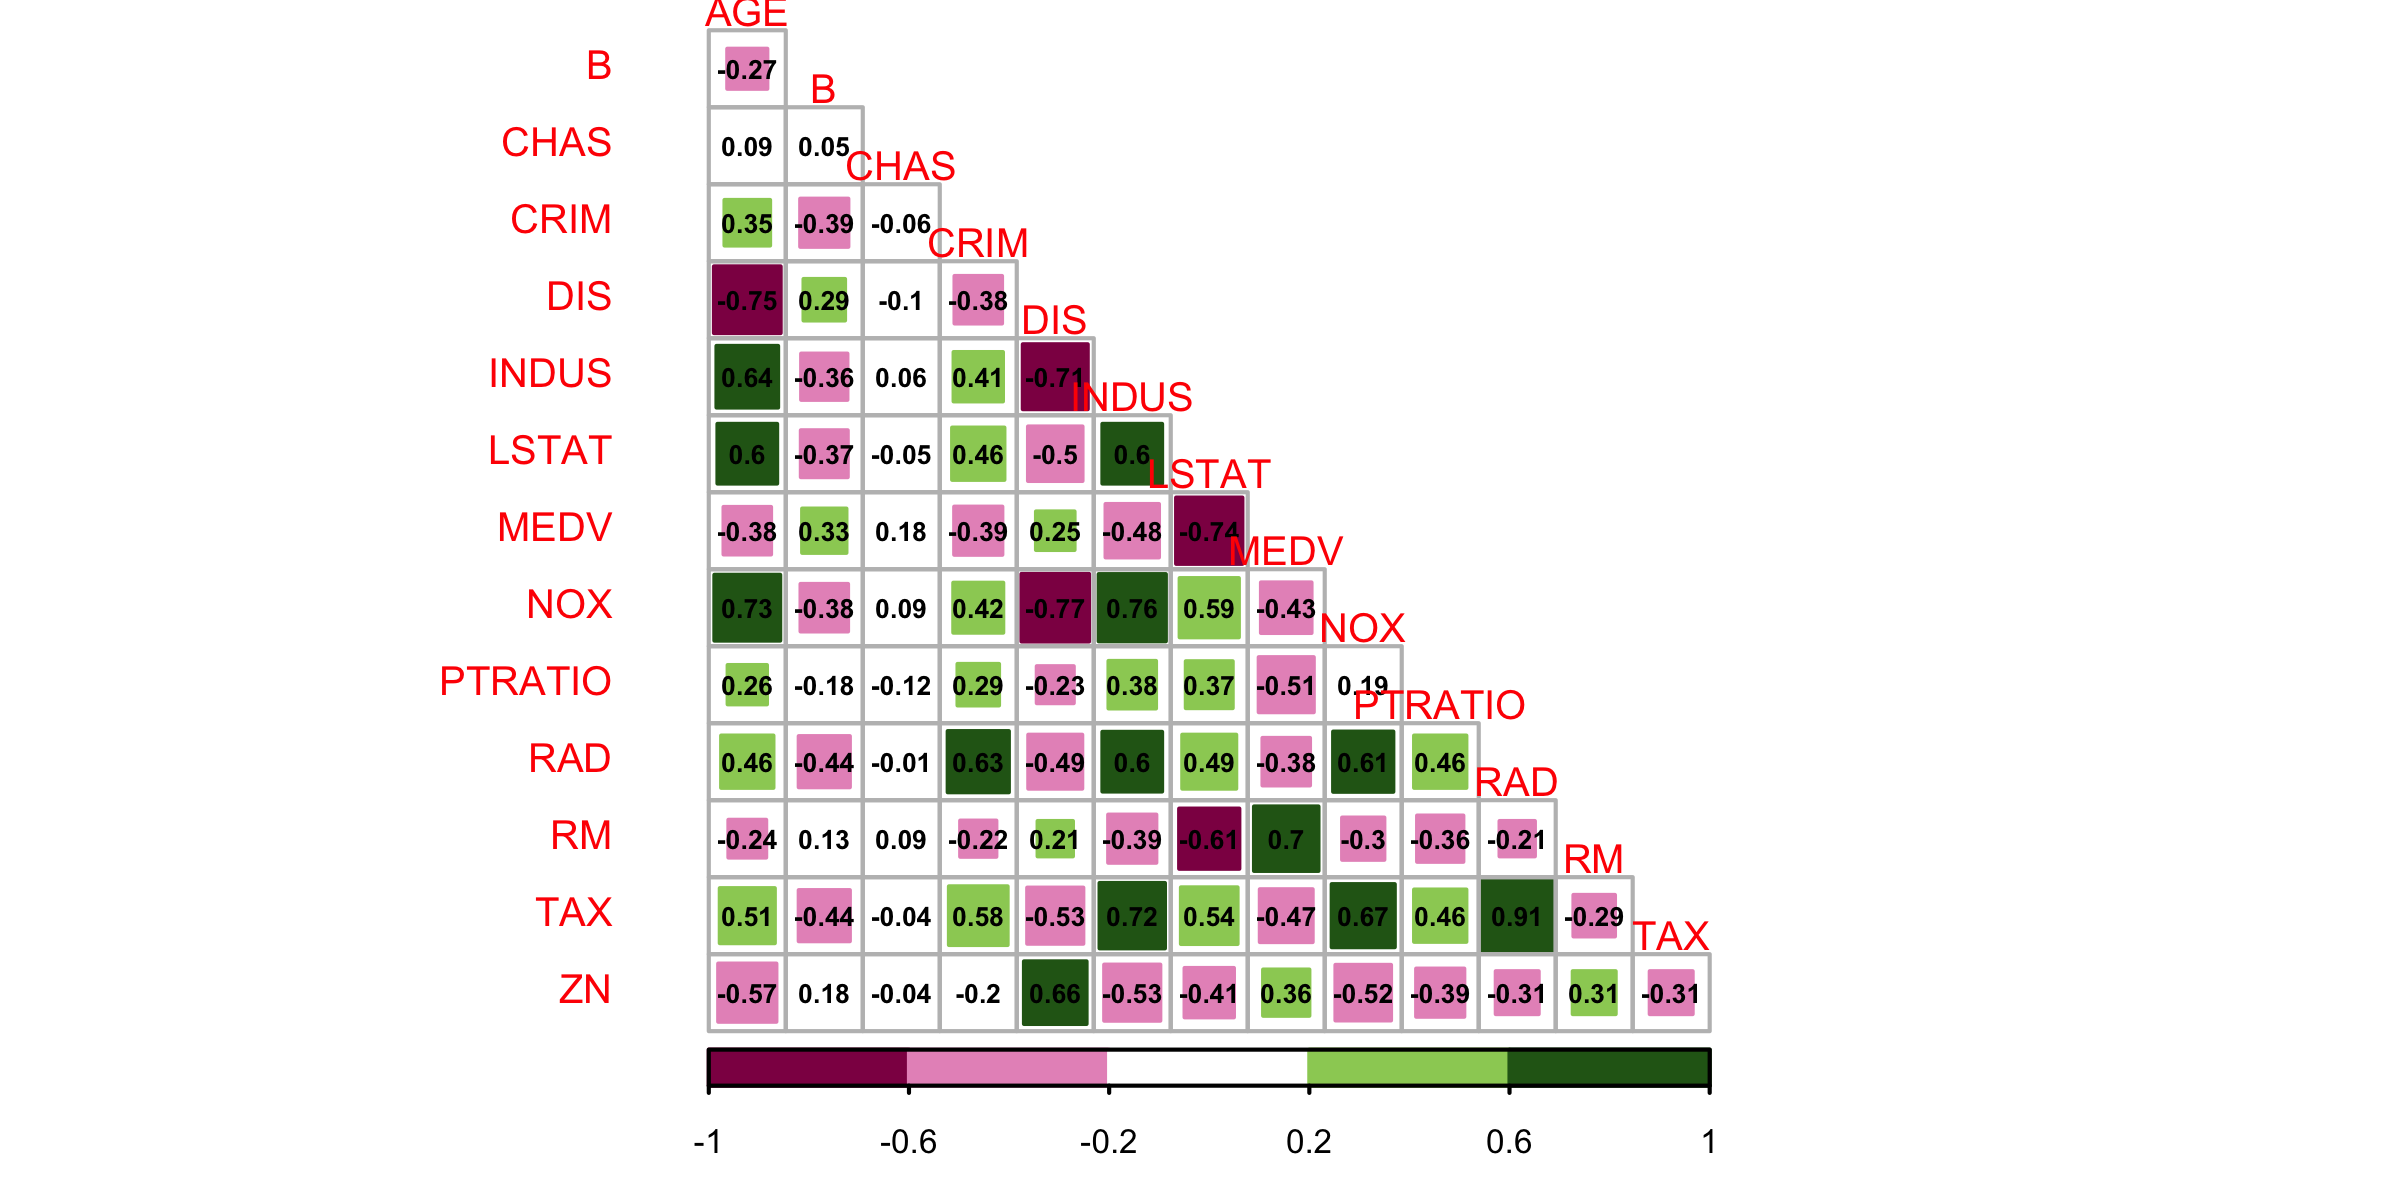

In [23]:
# Your code here

res <- round(cor(boston |> select(where(is.numeric))), 2)

corrplot(res,
  method = "square", type = "lower", diag = FALSE,
  addCoef.col = "black", number.cex = 0.4, cl.cex = 0.5, tl.cex = 0.6, tl.pos = "ld", tl.offset = 1.2,
  order = "alphabet", tl.srt = 0, col = COL2("PiYG", 5)
)

## 2.2 - Identifying Explanatory Variables

**Specifications**

- Based on the correllogram you created in Question 2.1, predict which variables are most likely to exhibit collinearity.
- From the 13 available explanatory variables, select 6 that you would like to use for your multiple linear regression (remember, the response variable is `MEDV`). 
- Provide a one-sentence rationale for why you chose each of the 6 variables for your analysis.

> Your answer here (predict which variables are most likely to exhibit collinearity)

> Your answer here (select 6 variables and provide a rationale for why)

## 2.3 - Multiple Linear Regression


**Specifications**

- Run a Multiple Linear Regression on the 6 explanatory variables you selected in Q2.2 and use the `MEDV` variable as the response variable.
- Save the model as `model1`, and produce two tibbles: one with the `regression_table()` and the other with the `fit_summary()`.

In [25]:
# Your code here

## 2.4 - Detecting multicollinearity


**Specifications**

- Using the function you created in Class 5, create a table of VIF values for all of the numeric variables in the `boston` dataset.
- You may also use the `vif()` function in the `car` package.

In [26]:
# Your code here

| Variable | VIF     |
| -------- | ------- |
| | |
| | |

## 2.5 - Addressing multicollinearity

At the end of Class 5, you were provided three different strategies to deal with multicollinearity in Linear Regression analyses.
In this question, you will use the `boston` dataset to explore some options to address multicollinearity.

In [27]:
# Your code here

### 2.5.1 - Drop a variable from your regression


**Specifications**

- 

In [ ]:
# Your code here

### 2.5.2 - Transform Variables

**Specifications**

- 

In [ ]:
# Your code here

### 2.5.3 - Ignore multicollinearity

**Specifications**

- 

In [ ]:
# Your code here

### 2.6 - Reflection Questions

**Specifications**

- You should answer each question with about 3-5 sentences and your responses should be concise, substantial, thoughtful, and reflective.
- You should also demonstrate a thorough understanding of the concept or question.

> Your answer here

> Your answer here

> Your answer here